In [1]:
import numpy as np
from scipy.stats import pearsonr
import scipy.signal as ss
import scipy.stats as scst
import saffy
from saffy.generators.svarog import svarog
import matplotlib.pyplot as plt
from scipy import signal
import mtmvar

In [2]:
pliki = {'open':'mateusz_oczy_szeroko_zamkniete', 'closed':'mateusz_oczy_zamkniete', 'inne':'mateusz_try1'}
EEG2 = saffy.SignalManager(generator=svarog(pliki['closed']))
CH = ['Fp1', 'P3', 'Pz', 'P4', 'Fp2', 'O1', 'O2','A1','A2']
EEG2.butter_highpass_filter(cutoff=1, order=5, method=None)
EEG2.extract_channels(CH)
EEG_2D_F = EEG2.data[0,:,:] #jest tylko jeden zestaw danych
EEG_2D_F = EEG_2D_F - (EEG_2D_F[-1,:] + EEG_2D_F[-2,:])/2 #montaz - średnia z uszu   
EEG_2D_F = EEG_2D_F[0:-2,:] #usuwamy kanały uszne
CH_N = EEG_2D_F.shape[0]

2020-01-14 12:09:51,307 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [3]:
syg1 = EEG_2D_F[0,:1000]
# fig = plt.figure(figsize = (25,5))
# plt.plot(syg1, linewidth=4)
# plt.show()

In [4]:
def widmo_AR(syg,p,Fs,f0=0,fmax=None,step = None):
    if fmax is None:
        fmax = int(Fs/2)
    if step is None:
        step = (fmax-f0)/Fs
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    freqz = np.arange(f0, fmax,step)
    ch = syg.shape[0]
    A_all, V = mtmvar.mult_AR(syg, p, 1)
    S_all = np.zeros((len(freqz),ch,ch),dtype="complex")
    A = np.eye(ch)
    for ind,fr in enumerate(freqz):
        A_temp = np.zeros((p,A_all.shape[1],A_all.shape[2]),dtype="complex")
        for p_prim in range(p):
            z = np.exp(2*np.pi*1j*fr*1/Fs*(-(p_prim+1)))
            A_temp[p_prim] = A_all[p_prim]*z
        Az = A-np.sum(A_temp,axis=0)
        Az_inv = np.linalg.inv(Az)
        Hf = Az_inv
        Hfconj = np.conj(Hf).T
        S1 = np.dot(Hf,V)
        S2 = np.dot(S1,Hfconj)
        S_all[ind,:,:] = S2
    return freqz,S_all

def proper_widmo_AR(sig,p,Fs,f0=0,fmax=None,step=None):
    if fmax is None:
        fmax = int(Fs/2)
    if step is None:
        step = (fmax-f0)/Fs
    if len(sig.shape) == 1:
        sig = np.reshape(sig,(1,-1))
    freqz = np.arange(f0, fmax,step)
    A, V = mtmvar.mult_AR(sig, p, 1)
    oczko = np.eye(A.shape[1])
    oczko = oczko[:,:,np.newaxis]
    z_freqz = np.exp(2*np.pi*1j*freqz*(1/Fs))**np.arange(-1,-p-1,-1).reshape((-1,1,1))
    z_freqz = np.squeeze(z_freqz)
    Az_temp = np.einsum('jik,jn->ikn',A,z_freqz)
    Az = oczko - Az_temp
    Hf = np.einsum('ijk->kij',Az)
    Hf = np.linalg.inv(Hf)
    Hfconj = np.einsum('kij->kji',np.conj(Hf))
    S1 = np.einsum('nij,jk->nik',Hf,V)
    S = np.einsum('hij,hjk->hik',S1,Hfconj)
    return freqz , S

def AIC(syg, min_order, max_order):
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    aic = np.zeros(max_order-min_order+1)
    k = syg.shape[0]
    N = syg.shape[1]
    for i, p in enumerate(range(min_order, max_order+1)):
        params, V = mtmvar.mult_AR(syg, p, 1)
        aic[i] = np.log(np.linalg.det(V)) + 2*p*k**2/N
    return aic

In [5]:
# AR = []
# for i in range(1,6):
#     AR.append(mtmvar.mult_AR(syg1, i, 1))

In [6]:
aic = AIC(syg1, 1, 20)
# fig = plt.figure(figsize = (15,5))
# plt.xticks(np.arange(1, 21, step=2))
# plt.plot(np.arange(1,21), aic, linewidth=4)
# plt.title('AIC for')
# plt.show()

### Ćwiczenie 2 - wykresy

In [7]:
Signal = EEG_2D_F[4:,21000:22000]
p=17
ch = Signal.shape[0]
freqsy , S_Signal = widmo_AR(Signal,p,EEG2.fs)
# plt.figure(figsize=(16,16))
for i in range(ch):
    for j in range(ch):
#         plt.subplot(ch,ch,i*ch+j+1)
        if i == j:
            widmo = np.abs(np.fft.rfft(Signal[i]))
            freq = np.fft.rfftfreq(len(Signal[i]),1/EEG2.fs)
#             plt.plot(freq,widmo,color = 'orange')
#         plt.plot(S_Signal[:,i,j],color='k')
# plt.show()
# print(S_Signal.shape)
# print(S_Signal[15,:,:])

In [8]:
syg3 = EEG_2D_F[0:6,:1000]
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
p = 250
ch = syg3.shape[0]-3
freqs,S_syg3 = widmo_AR(syg3,p,EEG2.fs,len(freq))
S_syg3 = np.abs(S_syg3)
for i in range(ch):
#     plt.figure(figsize=(12,4))
    widmo = np.abs(np.fft.rfft(syg3[i]))
    freq = np.fft.rfftfreq(len(syg3[i]),1/EEG2.fs)
#     plt.plot(freq,widmo,color = 'orange')
#     plt.plot(freqs,S_syg3[:,i,i],color='k')
#     plt.show()
    print(len(freq), len(freqs))
    print(f'moc sygnału dla rfft: {round(np.sum(widmo),2)} i dla AR: {round(np.sum(S_syg3[:,i,i]),2)}')

# plt.show()

501 256
moc sygnału dla rfft: 88894.05 i dla AR: 44180.99
501 256
moc sygnału dla rfft: 75031.8 i dla AR: 26465.95
501 256
moc sygnału dla rfft: 84993.46 i dla AR: 17793.5


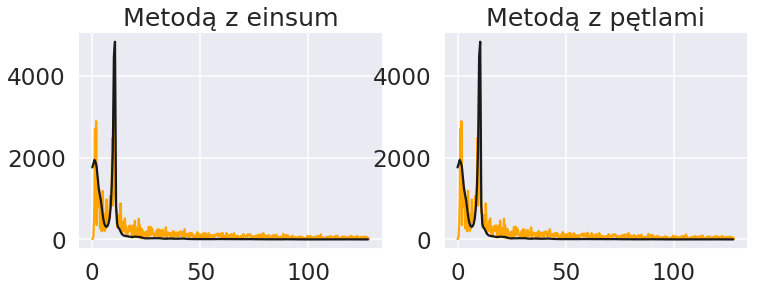

501 256
moc sygnału dla rfft: 88894.05, dla AR (einsum): 36462.59 i dla AR (pętle): 36462.59
maksymalna moc rfft: 4445.35 , AR (einsum): 4829.18 i dla AR (pętle): 4829.18


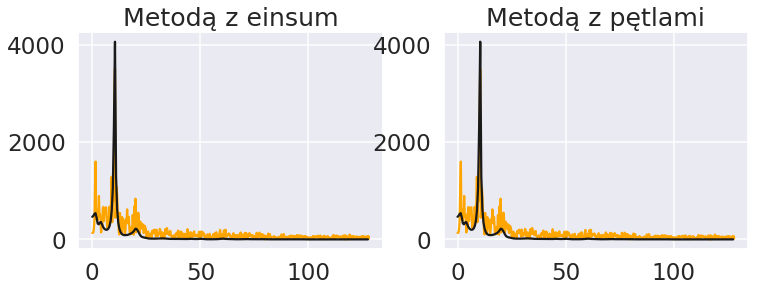

501 256
moc sygnału dla rfft: 75031.8, dla AR (einsum): 20870.01 i dla AR (pętle): 20870.01
maksymalna moc rfft: 3497.01 , AR (einsum): 4060.1 i dla AR (pętle): 4060.1


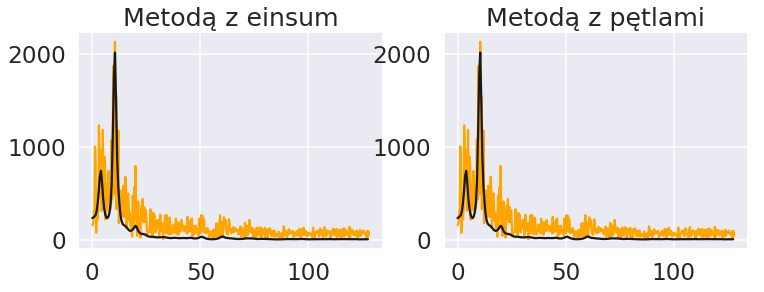

501 256
moc sygnału dla rfft: 84993.46, dla AR (einsum): 20967.94 i dla AR (pętle): 20967.94
maksymalna moc rfft: 2126.8 , AR (einsum): 2010.32 i dla AR (pętle): 2010.32


In [9]:
syg3 = EEG_2D_F[0:6,:1000]
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
p = 36
ch = syg3.shape[0]-3
freqs,S_syg3 = proper_widmo_AR(syg3,p,EEG2.fs)
freqs2,S_syg32 = widmo_AR(syg3,p,EEG2.fs)
S_syg3 = np.abs(S_syg3)
S_syg32 = np.abs(S_syg32)
for i in range(ch):
    plt.figure(figsize=(12,4))
    widmo = np.abs(np.fft.rfft(syg3[i]))
    freq = np.fft.rfftfreq(len(syg3[i]),1/EEG2.fs)
    plt.subplot(1,2,1)
    plt.title('Metodą z einsum')
    plt.plot(freq,widmo,color = 'orange')
    plt.plot(freqs,S_syg3[:,i,i],color='k')
    plt.subplot(1,2,2)
    plt.title('Metodą z pętlami')
    plt.plot(freq,widmo,color = 'orange')
    plt.plot(freqs,S_syg32[:,i,i],color='k')
#     plt.legend()
    plt.show()
    print(len(freq), len(freqs))
    print(f'moc sygnału dla rfft: {round(np.sum(widmo),2)}, dla AR (einsum): {round(np.sum(S_syg3[:,i,i]),2)} i dla AR (pętle): {round(np.sum(S_syg32[:,i,i]),2)}')
    print(f'maksymalna moc rfft: {round(np.max(widmo),2)} , AR (einsum): {round(np.max(S_syg3[:,i,i]),2)} i dla AR (pętle): {round(np.max(S_syg32[:,i,i]),2)}')
plt.show()

### TRAININIG WITH SIN

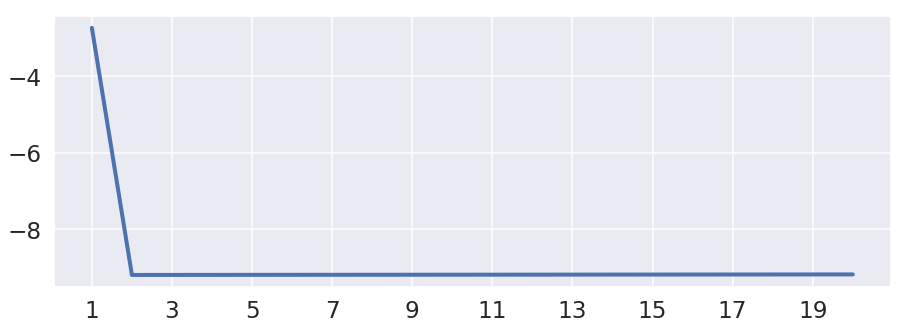

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

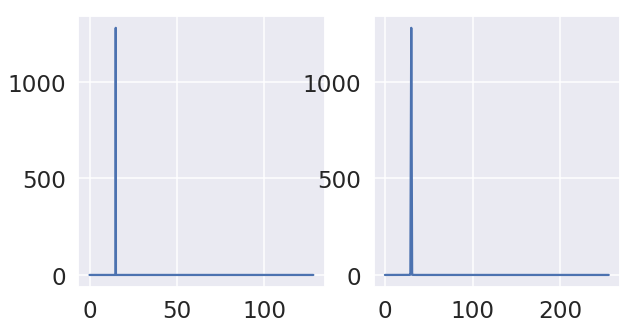

In [10]:
T=10
Fs=256
t = np.arange(0,T,1/Fs)
f = 15
sinus = np.sin(2*np.pi*f*t)
sinus = np.reshape(sinus,(1,-1))
aic = AIC(sinus,1,20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()
plt.figure(figsize=(15,5))
widmo = np.abs(np.fft.rfft(sinus[0]))
freq = np.fft.rfftfreq(len(sinus[0]),1/Fs)
plt.subplot(1,3,1)
plt.plot(freq,widmo)
# plt.show()

p=2
ch=0
fr,S_sinus = widmo_AR(sinus,p,Fs)
plt.subplot(1,3,2)
plt.plot(np.abs(S_sinus[:,ch,ch]))
# plt.show()
Fr , S_sin = proper_widmo_AR(sinus,p,Fs,step = Fs/2*100)
plt.subplot(1,3,3)
plt.plot(S_sin[:,ch,ch])
plt.show()
print(np.sum(widmo))
print(np.sum(np.abs(S_sinus[:,ch,ch])))
print(np.sum(np.abs(S_sin[:,ch,ch])))

### Zadanie 3
  Wygeneruj dwa sygnały sinusoidalne o długości 1000 próbek każdy, o tej samej częstości 32 Hz i częstości próbkowania 128 Hz, ale różnych fazach początkowych.
    Pierwszy sygnał powinien mieć fazę początkową równą 0, drugi sygnał sinusoidalny powinien mieć fazę początkową równą π/4.
    Do drugiego z sygnałów dodaj małą (o amplitudzie ok 0,2 amplitudy sinusoidy) składową losową (czyli dodatkowy niezależny szum biały).
    Z tak otrzymanych sygnałów utwórz jeden sygnał dwukanałowy (macierz o rozmiarze (2,1000)).

Podobnie jak poprzednio, ustal optymalny rząd modelu AR (tym razem dwukanałowego) i oblicz macierz gęstości widmowej mocy. Oblicz koherencje między tymi sygnałami. Narysuj moduł i fazę koherencji C12 i C21.

Zmień fazę początkową drugiego sygnału. Jak zmienia się funkcja koherencji? 

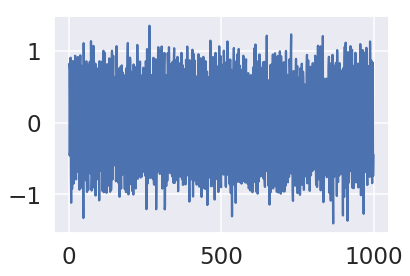

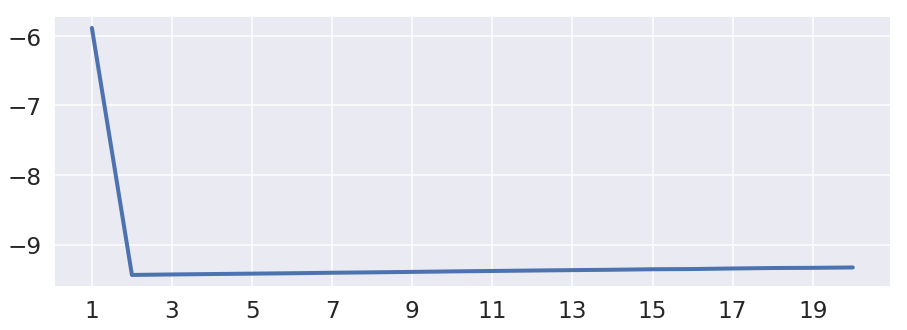

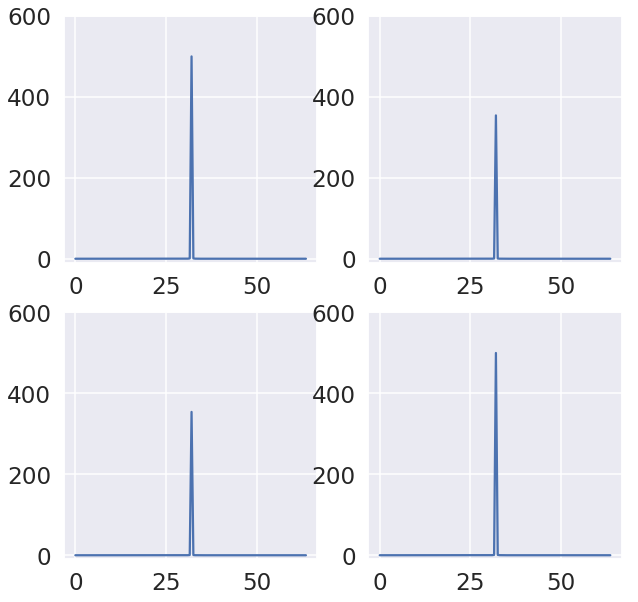

In [36]:
points = 1000
f = 32
Fs = 128
fi1 = 0
fi2 = np.pi/4
A=1
t = np.arange(0,points/Fs,1/Fs)
chann = 2
sinus1 = A*np.sin(2*np.pi*f*t+fi1)
sinus2 = A*np.sin(2*np.pi*f*t+fi2) + 0.2*A*np.random.randn(points)
# plt.plot(t,sinus1)
# plt.xlim(0,0.5)
# plt.show()
# plt.plot(t,sinus2)
# plt.xlim(0,0.5)
# plt.show()
sinus1 = np.reshape(sinus1,(1,points))
sinus2 = np.reshape(sinus2,(1,points))
sinus = np.concatenate((sinus1,sinus2),axis = 0)
sinus.shape
plt.plot(sinus[1])
plt.show()
aic = AIC(sinus,1,20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()
p=2
A,V=mtmvar.mult_AR(sinus, p, 1)
freqs,widmo_sin = proper_widmo_AR(sinus,p,Fs)
fig = plt.figure(figsize = (10,10))
for i in range(chann):
    for j in range(chann):
        
        plt.subplot(2,2,(chann*i)+j+1)
        plt.plot(freqs,widmo_sin[:,i,j])
        plt.ylim(-10,600)
plt.show()

(128, 2, 2)


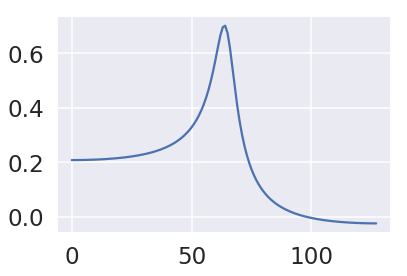

In [26]:
d = np.linalg.inv(widmo_sin)
print(d.shape)
C12 = (-1)**(2+1)* (d[:,1,0] / (d[:,0,0]*d[:,1,1])**(1/2)) 
plt.plot(C12)

In [32]:
def C(widmo):
    d = np.linalg.inv(widmo)
    output = np.zeros(widmo.shape, dtype='complex')
    for i in range(0, widmo.shape[1]):
        for j in range(0, widmo.shape[1]):
            output[:,i,j] = (-1)**(i+1+j+1)* (d[:,j,i] / (d[:,i,i]*d[:,j,j])**(1/2))
    return output

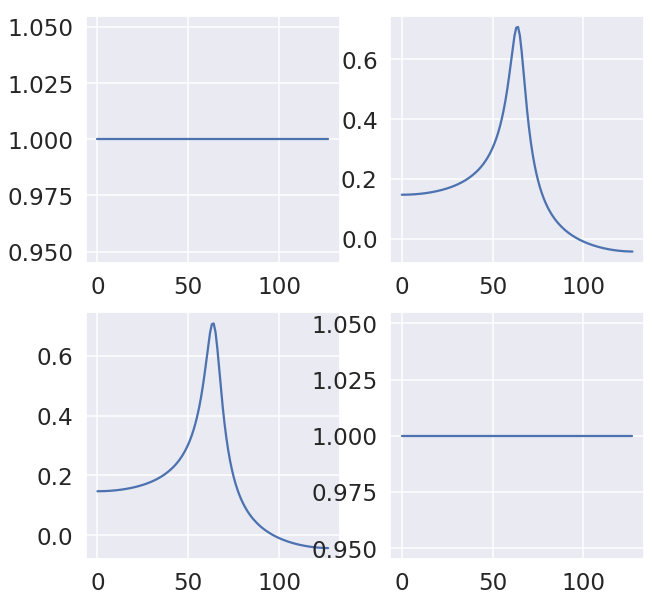

In [55]:
matrix = C(widmo_sin)
fig = plt.figure(figsize = (10,10))
for i in range(chann):
    for j in range(chann):
        
        plt.subplot(2,2,(chann*i)+j+1)
        plt.plot(matrix[:,i,j])
#         plt.ylim(-10,600)
plt.show()

In [72]:
points = 1000
f = 32
Fs = 128
fi1 = 0
fi2 = np.pi/4
A=1
t = np.arange(0,points/Fs,1/Fs)
chann = 2
sin1 = A*np.sin(2*np.pi*f*t+fi1)
sin2 = A*np.sin(2*np.pi*f*t+np.pi*2/3) + 0.2*A*np.random.randn(points)
sin1 = np.reshape(sin1,(1,points))
sin2 = np.reshape(sin2,(1,points))
sin = np.concatenate((sin1,sin2),axis = 0)
p=2

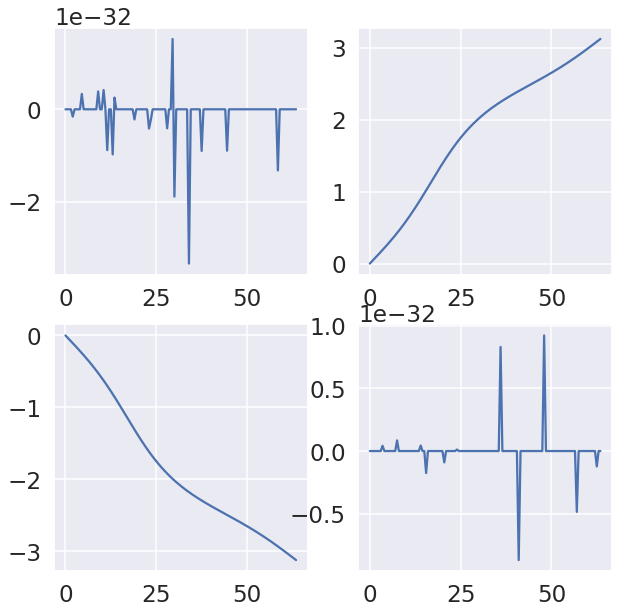

In [74]:

# A,V=mtmvar.mult_AR(sinus, p, 1)
freqs,widmo_sin2 = proper_widmo_AR(sin,p,Fs)

koh = C(widmo_sin2)
fig = plt.figure(figsize = (10,10))
for i in range(chann):
    for j in range(chann):
        
        plt.subplot(2,2,(chann*i)+j+1)
        plt.plot(freqs, np.angle(koh[:,i,j]))
#         plt.xlim(30,34)
#         plt.plot(freqs, matrix[:,i,j])
#         plt.ylim(-10,600)
plt.show()

In [87]:
signal = np.zeros((3,len(sin1)))
sin1 = A*np.sin(2*np.pi*f*t+fi1)
signal[0,:] = sin1
sin11 = 0.4*sin1 + 0.2*A*np.random.randn(points)
signal[1,:-1] = sin11[1:]
signal[1,-1] = sin11[0]

sin12 = 0.3*sin1 + 0.2*A*np.random.randn(points)
signal[2,:-2] = sin12[2:]
signal[2,-2:] = sin12[:2]

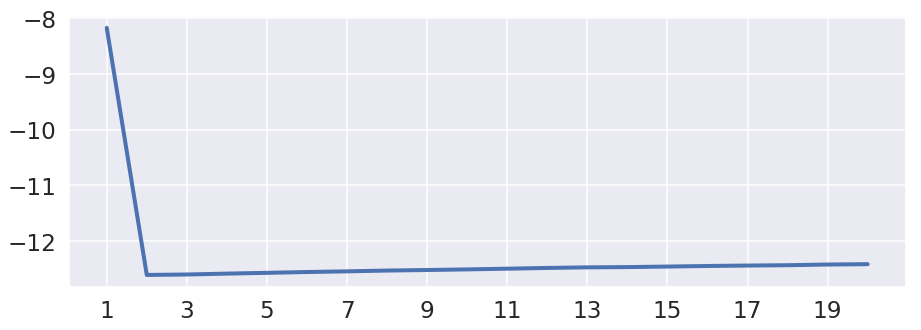

In [88]:
aic = AIC(signal,1,20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()

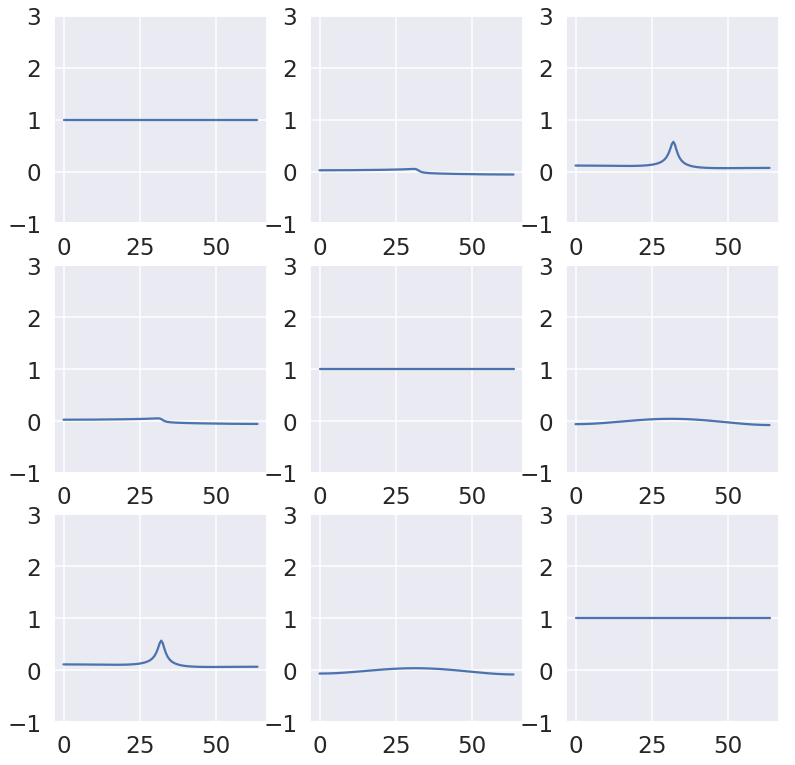

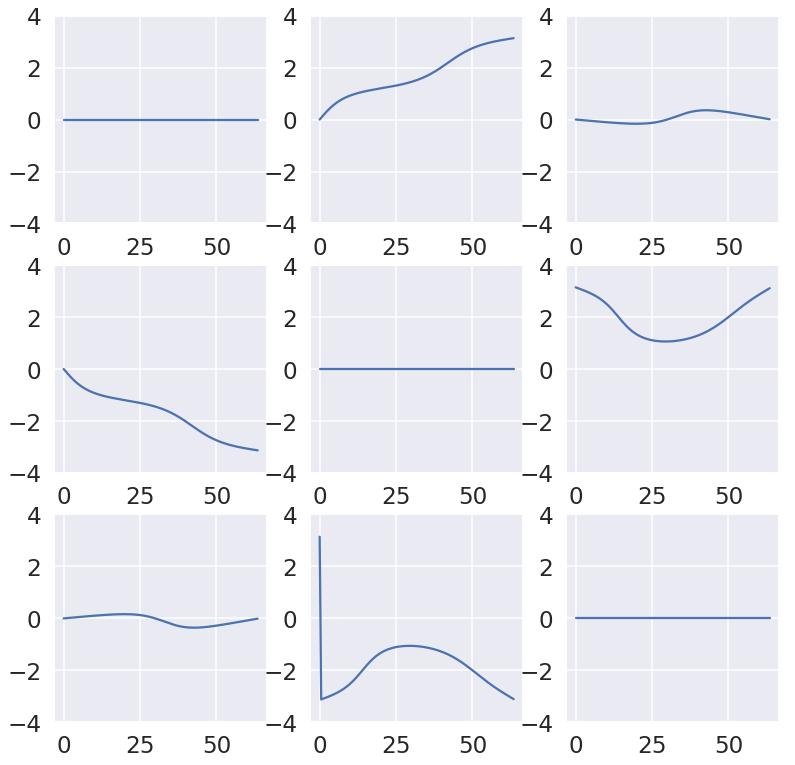

In [101]:
freqs,widmo_signal = proper_widmo_AR(signal,2,Fs=Fs)
Cs = C(widmo_signal)
fig = plt.figure(figsize = (13,13))
for i in range(3):
    for j in range(3):
        
        plt.subplot(3,3,(3*i)+j+1)
        plt.ylim(-1,3)
#         plt.plot(freqs, np.angle(Cs[:,i,j]))
        plt.plot(freqs, Cs[:,i,j])
plt.show()

fig = plt.figure(figsize = (13,13))
for i in range(3):
    for j in range(3):
        
        plt.subplot(3,3,(3*i)+j+1)
        plt.ylim(-4,4)
        plt.plot(freqs, np.angle(Cs[:,i,j]))
#         plt.plot(freqs, Cs[:,i,j])
plt.show()